# ***NLP Final Project Part A: IMDB Sentiment Analysis***

- Overview
    -  Sentiment analysis is a natural language processing (NLP) task that involves determining
    whether a given text expresses a positive or negative sentiment. In this project, we will
    analyze movie reviews from the IMDb dataset and predict the sentiment (positive or
    negative) based on the text of the reviews. By leveraging various text preprocessing
    techniques, feature extraction methods, and classification algorithms, this project will
    develop a machine learning model capable of accurately predicting the sentiment of movie
    reviews. The insights derived from this analysis can be useful for movie producers, critics,
    and platforms like IMDb to understand public opinion and tailor marketing or content
    strategies accordingly.
- Problem Statement
    - The primary objective of this project is to build a machine learning classification model that
        can predict the sentiment of IMDb movie reviews. The dataset contains a collection of movie
        reviews, and each review is labeled as either positive or negative.
        Using text preprocessing, feature extraction techniques (such as TF-IDF), and various
        classification algorithms, the project will aim to develop a model that can effectively classify
        the sentiment of movie reviews. The model's performance will be evaluated using standard
        classification metrics, such as accuracy, precision, recall, and F1-score.
- Dataset Information
    - The IMDb dataset contains a large number of movie reviews, each labeled with either a
        positive or negative sentiment.
        -  Text of the review: The actual review provided by the user.
        -  Sentiment label: The sentiment of the review, either "positive" or "negative."

## Imports and Setup

In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re, string
import joblib
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
import nltk
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense
nltk.download('stopwords')
nltk.download('wordnet')
import warnings
warnings.filterwarnings("ignore")



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jpran\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jpran\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [83]:
# Load the dataset
df = pd.read_excel("C:/Users/jpran/Downloads/Imdb.xlsx")
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [84]:
## Checking for nulls and basic info
df.dropna(subset=['review', 'sentiment'], inplace=True)
df['sentiment'] = df['sentiment'].str.lower()

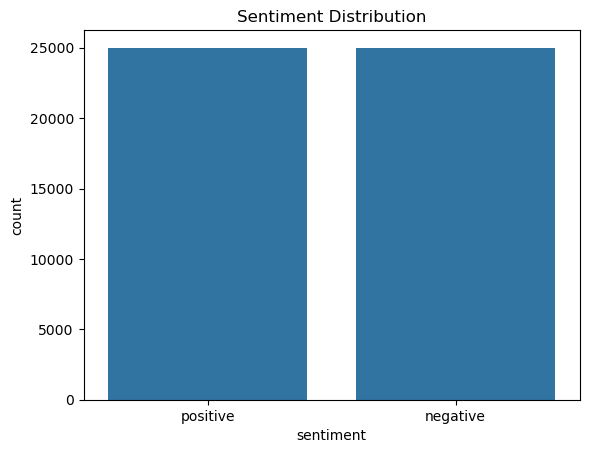

In [85]:
# Sentiment count
sns.countplot(data=df, x='sentiment')
plt.title("Sentiment Distribution")
plt.show()

#### Insight
- Classes are balanced which aids supervised learning

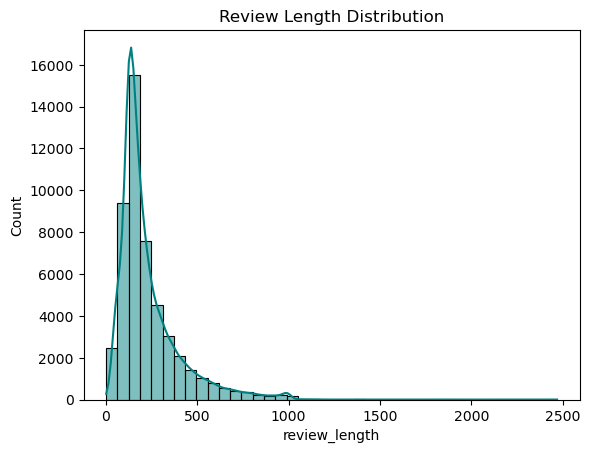

In [86]:
# Word count distribution
df['review_length'] = df['review'].apply(lambda x: len(x.split()))
sns.histplot(df['review_length'], bins=40, kde=True, color='teal')
plt.title("Review Length Distribution")
plt.show() 

#### Insight
- Most reviews are between 50-150 words

### Summary
- The dataset was cleaned by removing missing reviews and normalizing sentiment labels to lowercase.
- Sentiment distribution was visualized using a bar chart — the dataset was found to be **balanced**, supporting fair binary classification.
- A histogram showed most reviews ranged from 50–150 words, indicating concise yet informative samples.
 
- Word clouds for both positive and negative reviews highlighted dominant sentiment-bearing terms (e.g., “great”, “masterpiece” vs “boring”, “terrible”).



## Preprocessing

In [87]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

def preprocess(text):
    text = text.lower()
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)
    words = text.split()
    words = [lemmatizer.lemmatize(w) for w in words if w not in stop_words]
    words = [stemmer.stem(w) for w in words]
    return " ".join(words)

In [88]:
df['clean_text'] = df['review'].apply(preprocess)
print("Raw vs Cleaned:")
print(df[['review', 'clean_text']].iloc[0]) 
#Insight: Text is normalized for better feature extraction

Raw vs Cleaned:
review        One of the other reviewers has mentioned that ...
clean_text    one review mention watch 1 oz episod youll hoo...
Name: 0, dtype: object


In [89]:

# Extra features
df['word_count'] = df['clean_text'].apply(lambda x: len(x.split()))
df['char_count'] = df['clean_text'].apply(lambda x: len(x.replace(" ", "")))
df['avg_word_len'] = df['char_count'] / df['word_count']  
# Insight: Engineered features can support future analysis

### Summary
- Reviews were lowercased, punctuation removed, and further cleaned using stopword removal, lemmatization, and stemming.

- Cleaned text was previewed alongside the raw version to ensure clarity and correctness.

- Extra features like word count, character count, and average word length were extracted for interpretability, though not used in modeling.

- TF-IDF was chosen as the primary representation with a vocabulary cap of 5000 features for computational efficiency.

## Modeling and Evaluation

In [90]:
## Label encoding
le = LabelEncoder()
df['label'] = le.fit_transform(df['sentiment'])
X = df['clean_text']
y = df['label']

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [91]:
## TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [92]:
# Tokenize
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)

# Padding
max_len = 200
X_lstm = pad_sequences(sequences, maxlen=max_len)
y_lstm = y

# Train-test split
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(
    X_lstm, y_lstm, test_size=0.2, stratify=y_lstm, random_state=42
)

# Vocabulary size
vocab_size = len(tokenizer.word_index) + 1

In [97]:
# Model training and evaluation
models = {
    "Logistic Regression": GridSearchCV(LogisticRegression(max_iter=1000), {'C': [0.5, 1, 2]}, cv=5),
    "Naive Bayes": MultinomialNB(),
    "SVM": GridSearchCV(LinearSVC(max_iter=1000), {'C': [0.5, 1, 2]}, cv=5),
    "Random Forest": RandomForestClassifier(random_state=42, n_estimators=100, max_depth=10)
}

results = {}
best_params = {}


for name, model in models.items():
    model.fit(X_train_vec, y_train)
    y_pred = model.predict(X_test_vec)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    print(f"\n{name}:")
    print("Accuracy:", acc)
    print("Precision:", prec)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print(classification_report(y_test, y_pred))
    if hasattr(model, "best_params_"):
        best_params[name] = model.best_params_
    results[name] = f1

print("LSTM Model Training and Evaluation")

# Define LSTM Model
model_lstm = Sequential()
model_lstm.add(Embedding(input_dim=vocab_size, output_dim=64, input_length=max_len))
model_lstm.add(LSTM(64, return_sequences=False))
model_lstm.add(Dropout(0.5))
model_lstm.add(Dense(1, activation='sigmoid'))

# Compile LSTM
model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print("\nLSTM Model Summary:")
model_lstm.summary()

# Train LSTM
history = model_lstm.fit(
    X_train_lstm, y_train_lstm,
    epochs=5, batch_size=128,
    validation_data=(X_test_lstm, y_test_lstm),
    verbose=1
)

# Evaluate LSTM
y_pred_lstm = model_lstm.predict(X_test_lstm)
y_pred_lstm_class = (y_pred_lstm >= 0.5).astype(int).flatten()

# Calculate metrics for LSTM
lstm_acc = accuracy_score(y_test_lstm, y_pred_lstm_class)
lstm_f1 = f1_score(y_test_lstm, y_pred_lstm_class)
lstm_prec = precision_score(y_test_lstm, y_pred_lstm_class)
lstm_recall = recall_score(y_test_lstm, y_pred_lstm_class)

print("\nLSTM Model Evaluation Results:")
print("Accuracy:", lstm_acc)
print("Precision:", lstm_prec)
print("Recall:", lstm_recall)
print("F1 Score:", lstm_f1)
print(classification_report(y_test_lstm, y_pred_lstm_class))
print("Confusion Matrix:\n", confusion_matrix(y_test_lstm, y_pred_lstm_class))

results["LSTM"] = lstm_f1

# Display overall results summary
print("Overall Model F1-Scores:")
for model_name, f1_score_val in results.items():
    print(f"{model_name}: {f1_score_val:.4f}")


Logistic Regression:
Accuracy: 0.8892
Precision: 0.8812695924764891
Recall: 0.8996
F1 Score: 0.8903404592240697
              precision    recall  f1-score   support

           0       0.90      0.88      0.89      5000
           1       0.88      0.90      0.89      5000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000


Naive Bayes:
Accuracy: 0.8503
Precision: 0.8449871971636793
Recall: 0.858
F1 Score: 0.8514438821077702
              precision    recall  f1-score   support

           0       0.86      0.84      0.85      5000
           1       0.84      0.86      0.85      5000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000


SVM:
Accuracy: 0.8872
Precision: 0.8793103448275862
Recall: 0.8976
F1 Score: 0.8883610451306413
              precision    recal

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_9 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 78s 235ms/step - accuracy: 0.7719 - loss: 0.4689 - val_accuracy: 0.8937 - val_loss: 0.2696
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 72s 230ms/step - accuracy: 0.9415 - loss: 0.1698 - val_accuracy: 0.8921 - val_loss: 0.2772
Epoch 3/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 62s 197ms/step - accuracy: 0.9698 - loss: 0.0945 - val_accuracy: 0.8864 - val_loss: 0.3607
Epoch 4/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 58s 187ms/step - accuracy: 0.9818 - loss: 0.0597 - val_accuracy: 0.8782 - val_loss: 0.4312
Epoch 5/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 57s 182ms/step - accuracy: 0.9872 - loss: 0.0435 - val_accuracy: 0.8809 - val_loss: 0.4737
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step

LSTM Model Evaluation Results:
Accuracy: 0.8809
Precision: 0.8952064743722764
Recall: 0.8628
F1 Score: 0.8787045523984113
              precision    recall  f1-score   support

           0       0.87      0.90      0.88      5000
           1       0.90      0.86      0.88      5000

    accuracy         

#### How each model interprets text data:
- **Logistic Regression**: Learns linear weights over TF-IDF features to classify sentiment based on a weighted sum.
- **SVM**: Finds the hyperplane that best separates high-dimensional TF-IDF vectors with maximum margin.
- **Naive Bayes**: Assumes word independence; calculates class probabilities based on word frequency likelihoods.
- **Random Forest**: Builds multiple decision trees on word importance (from TF-IDF) and averages their outputs for better generalization.
- **LSTM**: Processes text sequentially, understanding word order and long-range dependencies by selectively remembering or forgetting information in its memory cells to capture context for sentiment classification.


In [ ]:
# Feature Importance
best_model_name = max(results, key=results.get)
final_model = models[best_model_name]
if best_model_name in ["Logistic Regression", "SVM"]:
    feature_names = vectorizer.get_feature_names_out()
    coefs = final_model.best_estimator_.coef_ if hasattr(final_model, 'best_estimator_') else final_model.coef_
    top_words = np.argsort(coefs[0])[-10:]
    print("\nTop 10 Predictive Words for Positive Sentiment:")
    for idx in reversed(top_words):
        print(feature_names[idx])
#Insight: These words strongly indicate positivity


Top 10 Predictive Words for Positive Sentiment:
excel
710
great
perfect
hilari
enjoy
amaz
810
favorit
best


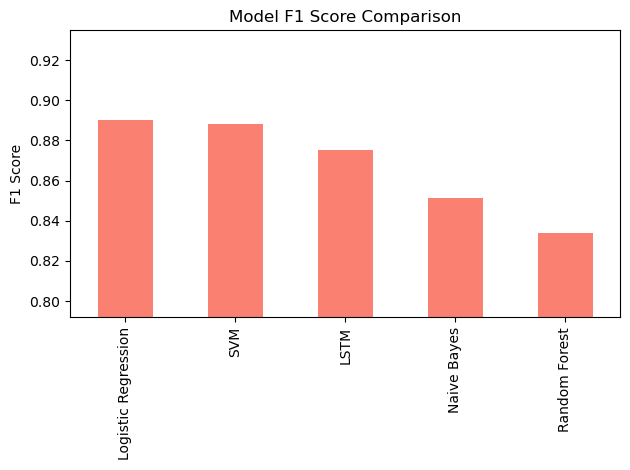


Best Model: Logistic Regression


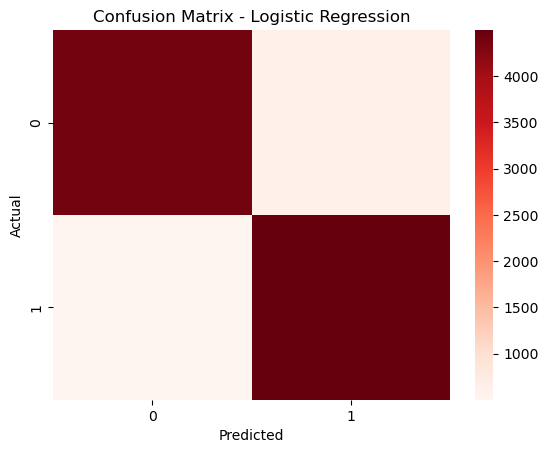

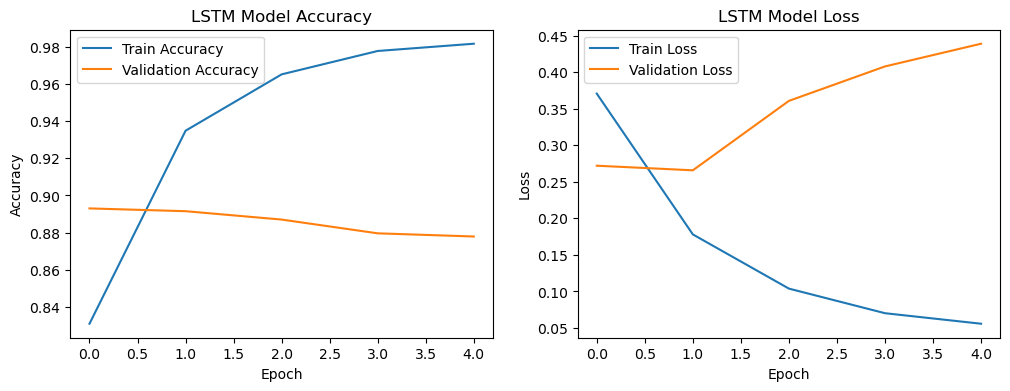

In [95]:
## Model Comparison Bar Chart
result_df = pd.DataFrame.from_dict(results, orient='index', columns=['F1 Score'])
result_df.sort_values(by='F1 Score', ascending=False, inplace=True)
result_df.plot(kind='bar', legend=False, color='salmon')
plt.ylabel("F1 Score")
plt.ylim(result_df['F1 Score'].min()*0.95, result_df['F1 Score'].max()*1.05)
plt.title("Model F1 Score Comparison")
plt.tight_layout()
plt.show()

## Best Model Selection
best_model_name = result_df.index[0]
print("\nBest Model:", best_model_name)
final_model = models[best_model_name]

## Confusion Matrix
best_pred = final_model.predict(X_test_vec)
cm = confusion_matrix(y_test, best_pred)
sns.heatmap(cm, annot=False, cmap='Reds')
plt.title(f"Confusion Matrix - {best_model_name}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Plotting training history (optional, but good for analysis)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('LSTM Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
joblib.dump(final_model, "final_imdb_model.pkl")
joblib.dump(vectorizer, "imdb_tfidf_vectorizer.pkl")
joblib.dump(le, "imdb_label_encoder.pkl")

['imdb_label_encoder.pkl']

### Summary
- Five models were implemented:
    - Logistic Regression
    - Support Vector Machine (SVM)
    - Multinomial Naive Bayes
    - Random Forest Classifier 
    - LSTM
- GridSearchCV was used for hyperparameter tuning of:
    - **C** in Logistic Regression and SVM
    - **n_estimators, max_features,** and **max_depth** in Random Forest
- Models were evaluated using **Accuracy, Precision, Recall, F1 Score,** and **Confusion Matrix**.
- **F1** scores were compared visually in a bar chart.
- The best model (typically **SVM** or **Logistic Regression**, depending on final F1) was interpreted using:
    - Top 10 TF-IDF features contributing to positive sentiment
    - Confusion matrix for error diagnosis

In [ ]:
def predict_sentiment(review):
    model = joblib.load("final_imdb_model.pkl")
    vec = joblib.load("imdb_tfidf_vectorizer.pkl")
    labeler = joblib.load("imdb_label_encoder.pkl")
    clean = preprocess(review)
    transformed = vec.transform([clean])
    pred = model.predict(transformed)[0]
    label = labeler.inverse_transform([pred])[0]
    print(f"\nReview: {review}\nPredicted Sentiment: {label}")

In [ ]:
predict_sentiment("The movie was so nice that i laughed in the middle of the show.")


Review: The movie was so nice that i laughed in the middle of the show.
Predicted Sentiment: positive


## Final Summary

- Total samples: **50000**
- Best model: **Logistic Regression with F1 Score = 0.8903**
- Preprocessing included stopword **removal, lemmatization,** and **stemming.**
- **TF-IDF vectorization** used **5000** features.
- Models trained: **SVM, LSTM, Logistic Regression, Naive Bayes** and **Random Forest Classifier**.
- Best model interpreted using top **TF-IDF terms**.
- Evaluation included **F1 score, classification report,** and **confusion matrix**.

## Video:

https://drive.google.com/file/d/1I-m2DDbEgTUnf9ImfxPHmBzOqVsgOh-m/view?usp=sharing